In [1]:
!pip install nibabel

In [2]:
!pip install keras

In [3]:
!pip install tensorflow

<h3> Importing Libraries</h3>

In [4]:
import pandas as pd                            # Standard Libraries for data analysis/science 
import nibabel as nib
import os
from PIL import Image, ImageSequence
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


import requests
import itertools

from zipfile import ZipFile
from io import BytesIO
from numpy import arange

from sklearn.preprocessing import LabelEncoder,OneHotEncoder,MinMaxScaler,PolynomialFeatures,StandardScaler,OrdinalEncoder # Primarily used for modeling and predictive data science 
from sklearn.linear_model import LinearRegression, PoissonRegressor, LogisticRegression, HuberRegressor,lasso_path, Lasso, Ridge, LassoCV
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV,GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.compose import make_column_selector as selector

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml, make_classification
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA


import tensorflow
import keras
from keras_preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Convolution2D
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from keras.layers.convolutional import MaxPooling2D


<h3> Loading a sample MRI image</h3>

In [5]:
path = r'C:\Capstone\Dataset\OAS1_0001_MR1\PROCESSED\MPRAGE\T88_111\OAS1_0001_MR1_mpr_n4_anon_111_t88_masked_gfc_tra_90.gif'
im = Image.open(path)

#C:\capstone\New folder\New folder\disc1\OAS1_0001_MR1\PROCESSED\MPRAGE\T88_111\OAS1_0001_MR1_mpr_n4_anon_111_t88_masked_gfc_tra_90.gif

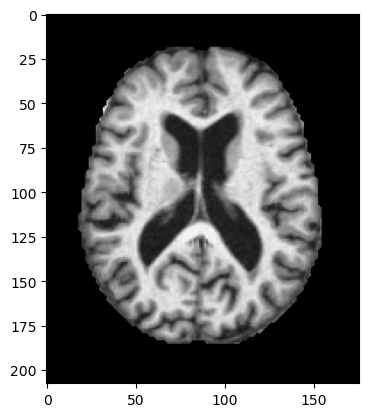

In [6]:
plt.imshow(im, cmap='gray')

<h3>Loading the Datasets</h3>

In [7]:
df = pd.read_excel(r'C:\Capstone\oasis_longitudinal_demographics.xlsx')

In [8]:
oasis1 = pd.read_csv(r'C:\Capstone\oasis_cross-sectional.csv')

In [9]:
df

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1986.550000,0.696106,0.883440
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004.479526,0.681062,0.875539
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678.290000,0.736336,1.045710
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1737.620000,0.713402,1.010000
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1697.911134,0.701236,1.033623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,OAS2_0185,OAS2_0185_MR2,Demented,2,842,M,R,82,16,1.0,28.0,0.5,1692.880000,0.693926,1.036690
369,OAS2_0185,OAS2_0185_MR3,Demented,3,2297,M,R,86,16,1.0,26.0,0.5,1688.009649,0.675457,1.039686
370,OAS2_0186,OAS2_0186_MR1,Nondemented,1,0,F,R,61,13,2.0,30.0,0.0,1319.020000,0.801006,1.330540
371,OAS2_0186,OAS2_0186_MR2,Nondemented,2,763,F,R,63,13,2.0,30.0,0.0,1326.650000,0.795981,1.322890


In [10]:
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1986.550000,0.696106,0.883440
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004.479526,0.681062,0.875539
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678.290000,0.736336,1.045710
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1737.620000,0.713402,1.010000
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1697.911134,0.701236,1.033623


<h3>Finding the nuumber of features and columns in the dataset</h3>

In [11]:
print("The number of features and columns in the dataset are:",df.shape)

The number of features and columns in the dataset are: (373, 15)


<h3>Changing the column names to be more appropriate</h3>

In [12]:
df.rename(columns = {'CDR':'Target'}, inplace = True)

In [13]:
df['Target'] = df['Target'].apply(lambda x: True if x>0 else False)

<h3>Datatypes of all the columns</h3>

In [14]:
df.dtypes

Subject ID     object
MRI ID         object
Group          object
Visit           int64
MR Delay        int64
M/F            object
Hand           object
Age             int64
EDUC            int64
SES           float64
MMSE          float64
Target           bool
eTIV          float64
nWBV          float64
ASF           float64
dtype: object

<h3>Unique values in each object columns</h3>

In [15]:
df['Subject ID'].value_counts()

OAS2_0070    5
OAS2_0048    5
OAS2_0127    5
OAS2_0073    5
OAS2_0034    4
            ..
OAS2_0071    2
OAS2_0069    2
OAS2_0068    2
OAS2_0066    2
OAS2_0092    2
Name: Subject ID, Length: 150, dtype: int64

In [16]:
df['MRI ID'].value_counts()#Since every Id is unique the values are expected to be 1.

OAS2_0001_MR1    1
OAS2_0118_MR2    1
OAS2_0122_MR2    1
OAS2_0122_MR1    1
OAS2_0121_MR2    1
                ..
OAS2_0057_MR3    1
OAS2_0057_MR2    1
OAS2_0057_MR1    1
OAS2_0056_MR2    1
OAS2_0186_MR3    1
Name: MRI ID, Length: 373, dtype: int64

In [17]:
df['Group'].value_counts()

Nondemented    190
Demented       146
Converted       37
Name: Group, dtype: int64

In [18]:
df['M/F'].value_counts()

F    213
M    160
Name: M/F, dtype: int64

In [19]:
df['Hand'].value_counts()#The dataset only contains informations regarding righthanded people

R    373
Name: Hand, dtype: int64

<h3>Number of null values in each column</h3>

In [20]:
df.isnull().sum()

Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           19
MMSE           2
Target         0
eTIV           0
nWBV           0
ASF            0
dtype: int64

In [21]:
# Dropping rows with 'NaN' character since mean or median values cannot be imputed due to sensitivity of health care data.
df =df.dropna()
df.reset_index(drop=True, inplace=True)

<h3>Finding the correlation between the columns</h3>

In [22]:
data =  df.drop(['Target'], axis=1)
Target=df['Target']

In [23]:
data.corr()

,Visit,MR Delay,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF
Visit,1.000000,0.922833,0.186306,0.013574,-0.051622,-0.029031,0.128767,-0.122558,-0.133928
MR Delay,0.922833,1.000000,0.204313,0.044399,-0.030813,0.073640,0.119419,-0.101283,-0.125145
Age,0.186306,0.204313,1.000000,-0.024977,-0.046857,0.055880,0.040244,-0.526578,-0.031528
EDUC,0.013574,0.044399,-0.024977,1.000000,-0.722647,0.184459,0.267952,-0.019877,-0.251646
SES,-0.051622,-0.030813,-0.046857,-0.722647,1.000000,-0.149219,-0.261582,0.089956,0.255448
MMSE,-0.029031,0.073640,0.055880,0.184459,-0.149219,1.000000,-0.019442,0.341450,0.027848
eTIV,0.128767,0.119419,0.040244,0.267952,-0.261582,-0.019442,1.000000,-0.206646,-0.989019
nWBV,-0.122558,-0.101283,-0.526578,-0.019877,0.089956,0.341450,-0.206646,1.000000,0.211003
ASF,-0.133928,-0.125145,-0.031528,-0.251646,0.255448,0.027848,-0.989019,0.211003,1.000000


C:\Users\abhin\AppData\Local\Temp\ipykernel_26456\2991745214.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(data.corr(), mask = np.triu(np.ones_like(data.corr(), dtype=np.bool)),linewidth=0.1, ax=ax)


<AxesSubplot:>

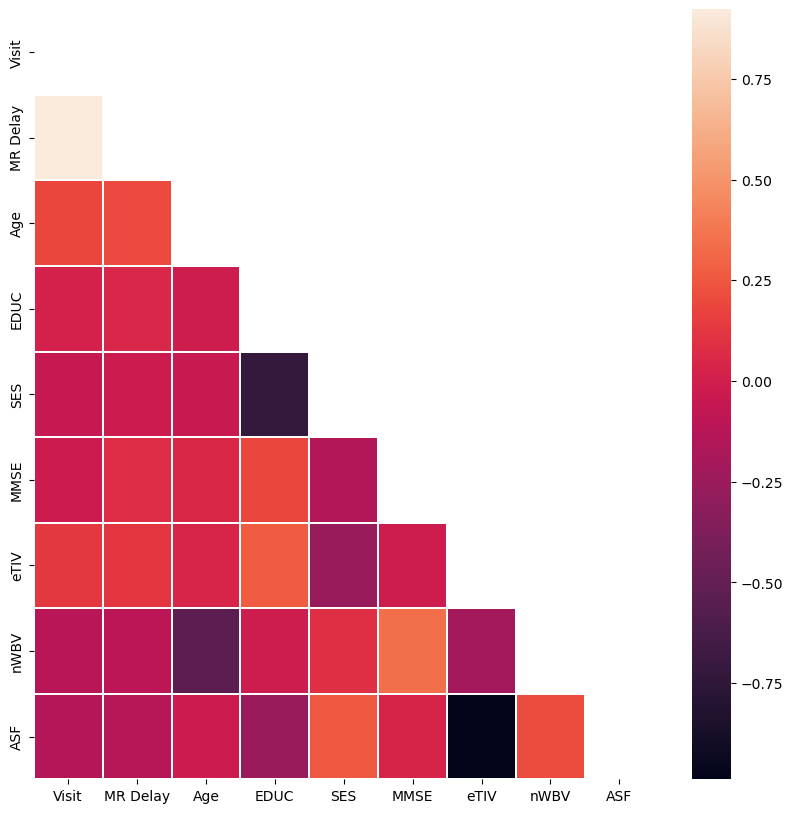

In [24]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(data.corr(), mask = np.triu(np.ones_like(data.corr(), dtype=np.bool)),linewidth=0.1, ax=ax)

<h3>Distribution of target column</h3>

In [25]:
Target.value_counts()

False    206
True     148
Name: Target, dtype: int64

<h3>Removing the columns which don't contribute to find the solution.</h3>

In [26]:
data.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,1986.550000,0.696106,0.883440
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,2004.479526,0.681062,0.875539
2,OAS2_0004,OAS2_0004_MR1,Nondemented,1,0,F,R,88,18,3.0,28.0,1215.330000,0.709512,1.444060
3,OAS2_0004,OAS2_0004_MR2,Nondemented,2,538,F,R,90,18,3.0,27.0,1200.100000,0.718214,1.462380
4,OAS2_0005,OAS2_0005_MR1,Nondemented,1,0,M,R,80,12,4.0,28.0,1688.580000,0.711502,1.039330


In [27]:
Target.head()

0    False
1    False
2    False
3    False
4    False
Name: Target, dtype: bool

In [28]:
data = data.drop(['Subject ID','MRI ID','Visit','Group','Hand'],axis=1)

In [29]:
data.head()

,MR Delay,M/F,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF
0,0,M,87,14,2.0,27.0,1986.550000,0.696106,0.883440
1,457,M,88,14,2.0,30.0,2004.479526,0.681062,0.875539
2,0,F,88,18,3.0,28.0,1215.330000,0.709512,1.444060
3,538,F,90,18,3.0,27.0,1200.100000,0.718214,1.462380
4,0,M,80,12,4.0,28.0,1688.580000,0.711502,1.039330


<h3>Normalize the data</h3>

In [30]:
#Getting numerical column names into one array
numerical_features = data.select_dtypes(include=[int, float]).columns
#Getting categorical column names into one array
categorical_features = data.select_dtypes(include=[object]).columns

In [31]:
numerical_features

Index(['MR Delay', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF'], dtype='object')

In [32]:
categorical_features

Index(['M/F'], dtype='object')

In [33]:
scaler = StandardScaler()
encoder = LabelEncoder()

In [34]:
#Applying the scalar on the data
data[numerical_features] = scaler.fit_transform(data[numerical_features])

In [35]:
for categorical_feature in categorical_features:
    data[categorical_feature] = encoder.fit_transform(data[categorical_features])

C:\Users\abhin\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [36]:
data

,MR Delay,M/F,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF
0,-0.940069,1,1.277580,-0.243255,-0.406615,-0.110484,2.829197,-0.893201,-2.271244
1,-0.225661,1,1.405772,-0.243255,-0.406615,0.698714,2.931351,-1.291257,-2.329067
2,-0.940069,0,1.405772,1.140076,0.476463,0.159249,-1.564876,-0.538486,1.831670
3,-0.099037,0,1.662157,1.140076,0.476463,-0.110484,-1.651650,-0.308236,1.965746
4,-0.940069,1,0.380232,-0.934921,1.359542,0.159249,1.131495,-0.485832,-1.130358
...,...,...,...,...,...,...,...,...,...
349,0.376193,1,0.636617,0.448410,-1.289694,0.159249,1.155994,-0.950883,-1.149679
350,2.650730,1,1.149387,0.448410,-1.289694,-0.380216,1.128245,-1.439562,-1.127753
351,-0.940069,0,-2.055426,-0.589088,-0.406615,0.698714,-0.974096,1.882394,1.000871
352,0.252695,0,-1.799041,-0.589088,-0.406615,0.698714,-0.930623,1.749435,0.944884


In [37]:
X = data #features
Y = Target #target

#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Target, random_state = 40)

<h3> Random Forest</h3>

In [38]:
rfc = RandomForestClassifier(random_state = 1)

In [39]:
n_estimators = [300, 1200]
max_depth = [None,5, 8, 15, 25, 30]
min_samples_split = [5, 10, 15, 50]
min_samples_leaf = [1, 2, 5, 10]

hyper_param = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridcv= GridSearchCV(rfc, hyper_param, cv = 10, verbose = 1, n_jobs = -1, scoring = 'accuracy', return_train_score=True)

In [40]:
RFC = gridcv.fit(X_train,y_train)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


In [41]:
model = RFC.best_estimator_

In [42]:
RFC.best_estimator_

RandomForestClassifier(min_samples_leaf=2, min_samples_split=5,
                       n_estimators=1200, random_state=1)

In [43]:
y_pred = model.predict(X_test)

In [44]:
model.score(X_train,y_train)

0.9893992932862191

In [45]:
model.score(X_test,y_test)

0.8309859154929577

<h3>Logistic Regression</h3>

In [46]:
log_reg = LogisticRegression()

In [47]:
np.logspace(-4,4,20)

array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04])

In [48]:
penalty = ['l1', 'l2', 'elasticnet', 'none']
max_iter = [100,300,500,1000]
verbose = [2,4]
C = np.logspace(-4,4,20)
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

hyper_param = dict(max_iter = max_iter, verbose = verbose, penalty = penalty, solver = solver, C = C)

gridcv= GridSearchCV(log_reg, hyper_param, cv = 10, verbose = 1, n_jobs = -1, scoring = 'accuracy', return_train_score=True)

In [49]:
LOG_REG = gridcv.fit(X_train,y_train)

Fitting 10 folds for each of 3200 candidates, totalling 32000 fits
[LibLinear]

C:\Users\abhin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
14400 fits failed out of a total of 32000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1600 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\abhin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\abhin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\abhin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueErr

In [50]:
model = LOG_REG.best_estimator_

In [51]:
LOG_REG.best_estimator_

LogisticRegression(C=0.23357214690901212, penalty='l1', solver='liblinear',
                   verbose=2)

In [52]:
y_pred = model.predict(X_test)

In [53]:
model.score(X_train,y_train)

0.8197879858657244

In [54]:
model.score(X_test,y_test)

0.8591549295774648

In [55]:
print(LOG_REG.best_estimator_.coef_)
print(LOG_REG.best_estimator_.intercept_)

[[ 0.01511627  0.43194333 -0.34643337 -0.12329444  0.         -2.58419095
   0.         -0.63194357  0.        ]]
[0.]


In [56]:
confusion_matrix(y_test, y_pred)

array([[39,  2],
       [ 8, 22]], dtype=int64)

<h3>Working on the MRI data set and the medical dataset linked to it</h3>

In [57]:
oasis1

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
431,OAS1_0285_MR2,M,R,20,NaN,NaN,NaN,NaN,1469,0.847,1.195,2.0
432,OAS1_0353_MR2,M,R,22,NaN,NaN,NaN,NaN,1684,0.790,1.042,40.0
433,OAS1_0368_MR2,M,R,22,NaN,NaN,NaN,NaN,1580,0.856,1.111,89.0
434,OAS1_0379_MR2,F,R,20,NaN,NaN,NaN,NaN,1262,0.861,1.390,2.0


In [58]:
n = "OAS1_0001_MR1"
path = "C:\\Capstone\\Dataset\\" + n +"\PROCESSED\\MPRAGE\\T88_111\\"+ n + "_mpr_n4_anon_111_t88_masked_gfc_tra_90.gif"

#print(path)

im = Image.open(path)

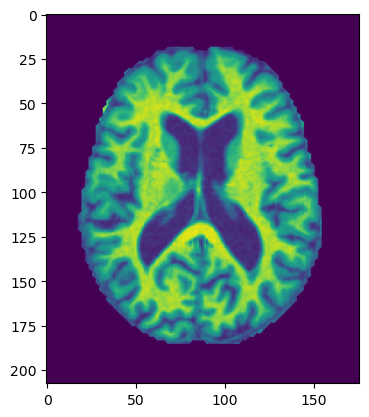

In [59]:
plt.imshow(im)

In [60]:
id_list = []
image_list = []
for i in range(oasis1.shape[0]):
    path1 = "C:\\Capstone\\Dataset\\" + oasis1.loc[i][0] +"\\PROCESSED\\MPRAGE\\T88_111\\"+ oasis1.loc[i][0] + "_mpr_n4_anon_111_t88_masked_gfc_tra_90.gif"
    path2 = "C:\\Capstone\\Dataset\\" + oasis1.loc[i][0] +"\\PROCESSED\\MPRAGE\\T88_111\\"+ oasis1.loc[i][0] + "_mpr_n3_anon_111_t88_masked_gfc_tra_90.gif"
    path3 = "C:\\Capstone\\Dataset\\" + oasis1.loc[i][0] +"\\PROCESSED\\MPRAGE\\T88_111\\"+ oasis1.loc[i][0] + "_mpr_n6_anon_111_t88_masked_gfc_tra_90.gif"
    #print(oasis1.loc[i][0])
    #print(path)
    if os.path.exists(path1):
        im = Image.open(path1)
    elif os.path.exists(path2):
        im = Image.open(path2)
    elif os.path.exists(path3):
        im = Image.open(path3)
#     try:
#         im = Image.open(path1)
#     except : 
#         im = Image.open(path2)
    image = np.asarray(im)
    image_list.append(image)
    id_list.append(oasis1.loc[i][0])
image_array = np.asarray(image_list)
    #print(path)

In [61]:
oasis1['Images'] = image_list

In [62]:
oasis1

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay,Images
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,OAS1_0285_MR2,M,R,20,NaN,NaN,NaN,NaN,1469,0.847,1.195,2.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
432,OAS1_0353_MR2,M,R,22,NaN,NaN,NaN,NaN,1684,0.790,1.042,40.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
433,OAS1_0368_MR2,M,R,22,NaN,NaN,NaN,NaN,1580,0.856,1.111,89.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
434,OAS1_0379_MR2,F,R,20,NaN,NaN,NaN,NaN,1262,0.861,1.390,2.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [63]:
oasis1.isnull().sum()

ID          0
M/F         0
Hand        0
Age         0
Educ      201
SES       220
MMSE      201
CDR       201
eTIV        0
nWBV        0
ASF         0
Delay     416
Images      0
dtype: int64

In [64]:
oasis1['CDR'].fillna(0, inplace=True)

In [65]:
oasis1['CDR'].value_counts()

0.0    336
0.5     70
1.0     28
2.0      2
Name: CDR, dtype: int64

In [66]:
#Creating a dataset with images, image Id's and CDR values
dataset = oasis1[['ID','CDR','Images']]

In [67]:
dataset

,ID,CDR,Images
0,OAS1_0001_MR1,0.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,OAS1_0002_MR1,0.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,OAS1_0003_MR1,0.5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,OAS1_0004_MR1,0.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,OAS1_0005_MR1,0.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...
431,OAS1_0285_MR2,0.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
432,OAS1_0353_MR2,0.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
433,OAS1_0368_MR2,0.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
434,OAS1_0379_MR2,0.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [68]:
total_subjects = os.listdir('C:\Capstone\Dataset')

In [69]:
image_array.shape

(436, 208, 176)

In [70]:
dataset['CDR'][1]

0.0

In [71]:
dataset['CDR'] = dataset['CDR'].apply(lambda x: 1 if x>0 else 0)

C:\Users\abhin\AppData\Local\Temp\ipykernel_26456\2051892623.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['CDR'] = dataset['CDR'].apply(lambda x: 1 if x>0 else 0)


In [72]:
y = np.asarray(dataset['CDR']) # diagnosis
x = image_array.reshape(-1, image_array.shape[1], image_array.shape[2],1) # Images

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 42) # split into test and train sets

In [73]:
model = Sequential()
model.add(Conv2D(100, (10, 10), strides=(20,20),activation='sigmoid', padding ='same',input_shape=(image_array.shape[1],image_array.shape[2],1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(100, (5, 5), strides=(15,15),activation='sigmoid', padding ='same'))
#model.add(MaxPooling2D(pool_size=(1, 1)))
model.add(Conv2D(50, (3, 3), strides=(15,15), activation='sigmoid', padding ='same'))
model.add(Conv2D(50, (3, 3), strides=(10,10), activation='sigmoid', padding ='same'))
model.add(Conv2D(50, (3, 3), strides=(5,5),  activation='sigmoid', padding ='same'))
model.add(Conv2D(50, (3, 3), strides=(3,3), activation='sigmoid', padding ='same'))
#model.add(MaxPooling2D(pool_size=(1, 1)))
model.add(Conv2D(25, (3,3), strides = (1,1), activation='sigmoid', padding ='same'))
model.add(MaxPooling2D(pool_size=(1, 1)))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [74]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 11, 9, 100)        10100     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 5, 4, 100)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 1, 100)         250100    
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 50)          45050     
                                                                 
 conv2d_3 (Conv2D)           (None, 1, 1, 50)          22550     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 1, 50)          22550     
                                                        

In [75]:
Image_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
)

In [76]:
#fitting the model without Validation
History = model.fit(Image_gen.flow(x_train, y_train, batch_size = 100), epochs = 500, validation_data = (x_test,y_test), verbose = 1)

Epoch 1/500
4/4 [==============================] - 2s 282ms/step - loss: 0.6949 - accuracy: 0.4648 - val_loss: 0.6549 - val_accuracy: 0.7890
Epoch 2/500
4/4 [==============================] - 1s 210ms/step - loss: 0.6439 - accuracy: 0.7645 - val_loss: 0.6050 - val_accuracy: 0.7890
Epoch 3/500
4/4 [==============================] - 1s 192ms/step - loss: 0.6043 - accuracy: 0.7645 - val_loss: 0.5688 - val_accuracy: 0.7890
Epoch 4/500
4/4 [==============================] - 1s 271ms/step - loss: 0.5734 - accuracy: 0.7645 - val_loss: 0.5438 - val_accuracy: 0.7890
Epoch 5/500
4/4 [==============================] - 1s 194ms/step - loss: 0.5596 - accuracy: 0.7645 - val_loss: 0.5283 - val_accuracy: 0.7890
Epoch 6/500
4/4 [==============================] - 1s 194ms/step - loss: 0.5513 - accuracy: 0.7645 - val_loss: 0.5201 - val_accuracy: 0.7890
Epoch 7/500
4/4 [==============================] - 1s 195ms/step - loss: 0.5470 - accuracy: 0.7645 - val_loss: 0.5166 - val_accuracy: 0.7890
Epoch 8/500
4

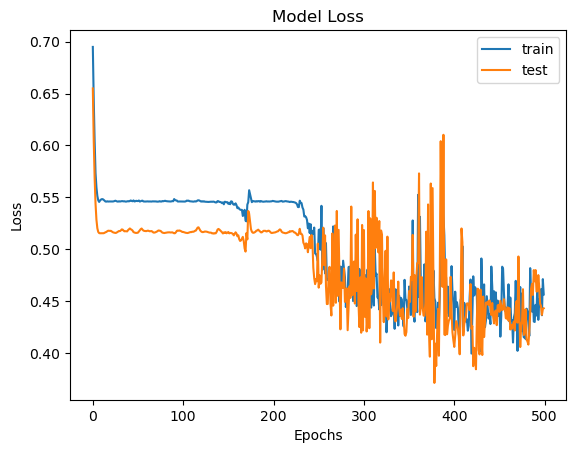

In [77]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train','test'])
plt.show()

In [78]:
#fitting the model with Validation
History = model.fit(x_train, y_train, batch_size = 100, epochs = 1000, validation_data = (x_test,y_test), verbose = 1)

Epoch 1/1000
4/4 [==============================] - 0s 36ms/step - loss: 0.4852 - accuracy: 0.7676 - val_loss: 0.4575 - val_accuracy: 0.8073
Epoch 2/1000
4/4 [==============================] - 0s 39ms/step - loss: 0.5096 - accuracy: 0.7706 - val_loss: 0.4400 - val_accuracy: 0.7890
Epoch 3/1000
4/4 [==============================] - 0s 39ms/step - loss: 0.5179 - accuracy: 0.7645 - val_loss: 0.4550 - val_accuracy: 0.8349
Epoch 4/1000
4/4 [==============================] - 0s 32ms/step - loss: 0.5244 - accuracy: 0.7584 - val_loss: 0.4178 - val_accuracy: 0.7890
Epoch 5/1000
4/4 [==============================] - 0s 32ms/step - loss: 0.5051 - accuracy: 0.7737 - val_loss: 0.3967 - val_accuracy: 0.8165
Epoch 6/1000
4/4 [==============================] - 0s 37ms/step - loss: 0.4665 - accuracy: 0.7859 - val_loss: 0.4503 - val_accuracy: 0.8624
Epoch 7/1000
4/4 [==============================] - 0s 52ms/step - loss: 0.4627 - accuracy: 0.7676 - val_loss: 0.3920 - val_accuracy: 0.8073
Epoch 8/1000


In [81]:
History.best_estimator_

AttributeError: 'History' object has no attribute 'best_estimator_'

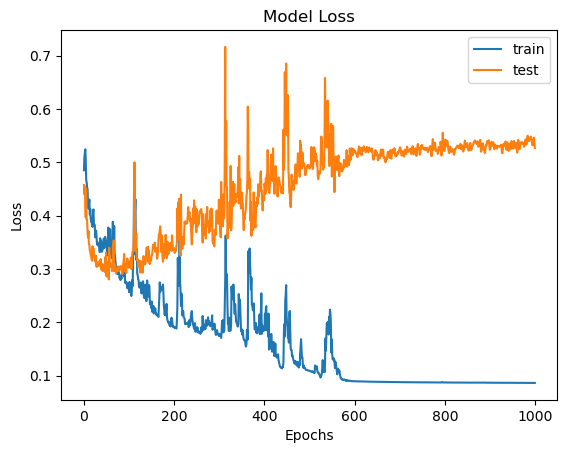

In [79]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train','test'])
plt.show()